# Clustering Medicare Drugs by Spending Patterns (2019–2023)
Goal: Group drugs into clusters based on their spending trends over 5 years (2019–2023).
This can help us identify fast-growing drugs, stable drugs, and declining drugs.

Shape after filtering: (3474, 6)


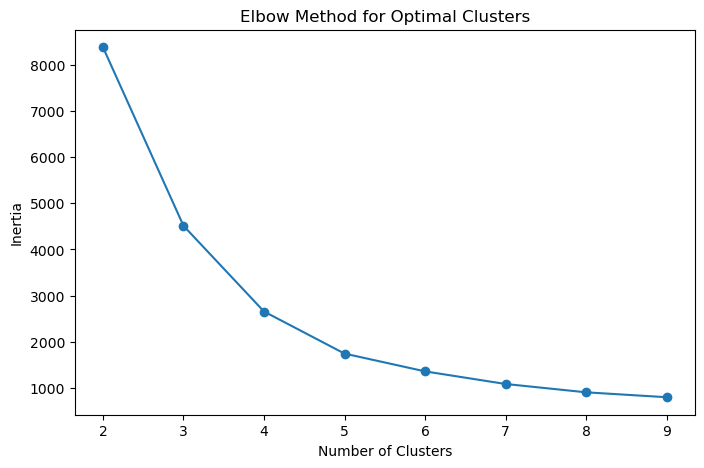

Cluster
0    3382
2      82
1       9
3       1
Name: count, dtype: int64


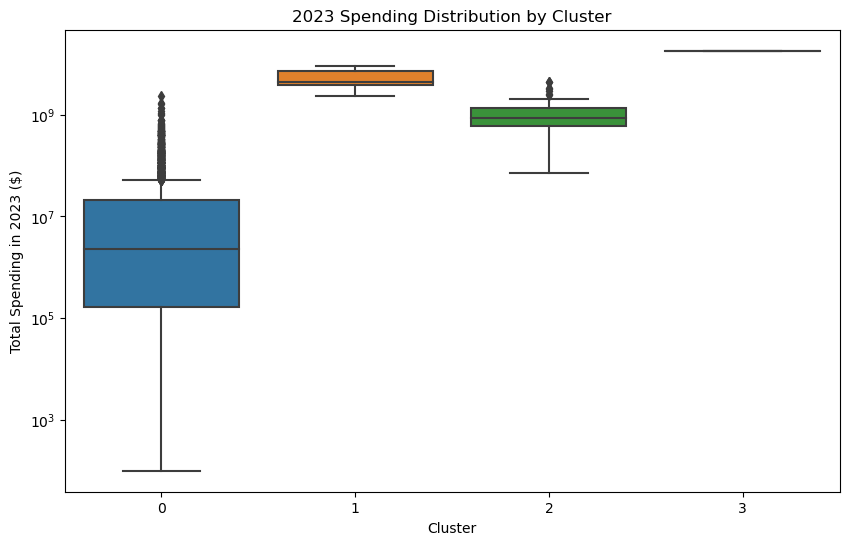

In [2]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


file_path = r"C:\Users\pro\Downloads\medicare-drug-spending-analysis\data\processed\medicare_drug_spending_clean.csv"
df = pd.read_csv(file_path)


df = df[df['Mftr_Name'] != "Overall"]


year_cols = ['Tot_Spndng_2019','Tot_Spndng_2020','Tot_Spndng_2021','Tot_Spndng_2022','Tot_Spndng_2023']

df_cluster = df.groupby('Brnd_Name')[year_cols].sum().reset_index()


df_cluster = df_cluster[df_cluster[year_cols].sum(axis=1) > 0]

print(f"Shape after filtering: {df_cluster.shape}")


scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_cluster[year_cols])

# ---  Elbow Method (to choose optimal k) ---
inertia = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(range(2, 10), inertia, marker='o')
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_cluster['Cluster'] = kmeans.fit_predict(scaled_data)

print(df_cluster['Cluster'].value_counts())

plt.figure(figsize=(10,6))
sns.boxplot(data=df_cluster, x='Cluster', y='Tot_Spndng_2023')
plt.title("2023 Spending Distribution by Cluster")
plt.ylabel("Total Spending in 2023 ($)")
plt.xlabel("Cluster")
plt.yscale('log')  
plt.show()


Optimal clusters: Using the Elbow Method, the best number of clusters was found to be 4.

Cluster distribution:

* Cluster 0 (3382 drugs): Majority of drugs, with very low Medicare spending — these represent low-cost or rarely used drugs.

* Cluster 1 (9 drugs): High-cost blockbuster drugs with multi-billion-dollar spending — major drivers of total Medicare drug costs.

* Cluster 2 (82 drugs): Mid-tier drugs with moderate but significant spending, showing consistent usage and adoption.

* Cluster 3 (1 drug): A single extreme outlier drug with extraordinarily high spending, which requires further investigation.

# Visualize clusters in 2D using PCA

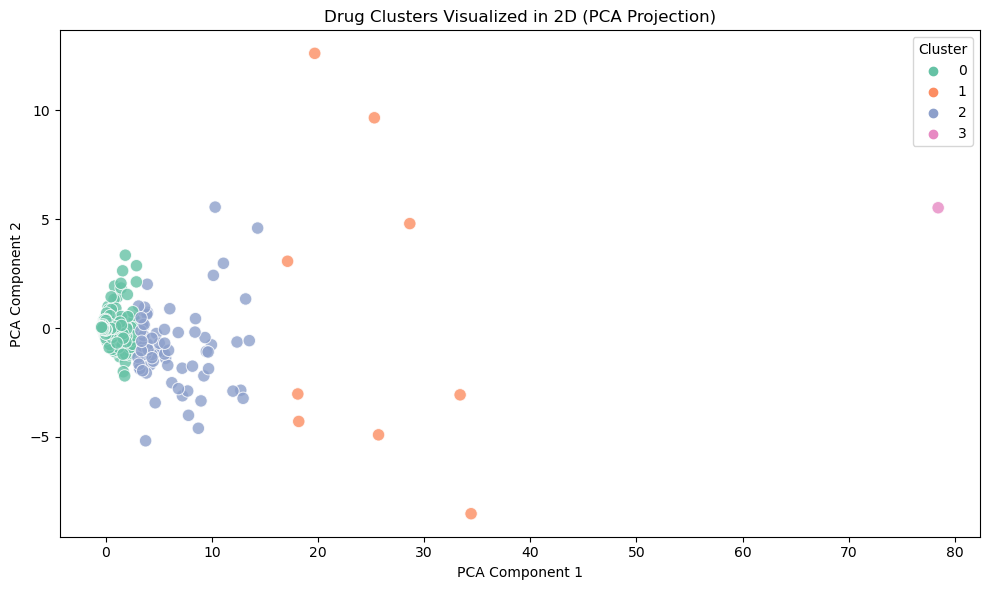

In [8]:


from sklearn.decomposition import PCA

# --- PCA for 2D projection ---
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

df_cluster['PCA1'] = pca_data[:, 0]
df_cluster['PCA2'] = pca_data[:, 1]

# --- Plot the clusters ---
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_cluster, x='PCA1', y='PCA2', hue='Cluster', palette='Set2', s=80, alpha=0.8)
plt.title("Drug Clusters Visualized in 2D (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()




- **Cluster 0 (Green):**  
  - Large group of drugs with **similar low to moderate spending patterns**.  
  - Represents the **bulk of the dataset** with stable trends.  

- **Cluster 1 (Orange):**  
  - Contains a **few high-spending drugs** scattered farther away.  
  - These are **special outliers**, likely representing **fast-growing or high-market-share drugs**.  

- **Cluster 3 (Pink):**  
  - **One extreme outlier**, likely **Eliquis**, dominating total spending.  
  - This drug behaves **very differently** compared to others.  

- **Cluster 2 (Blue):**  
  - A **mid-sized group** with **distinct spending patterns**.  
  - Likely includes **drugs with consistent but moderate growth**.


PCA1 explains: 94.37% of variance
PCA2 explains: 5.01% of variance


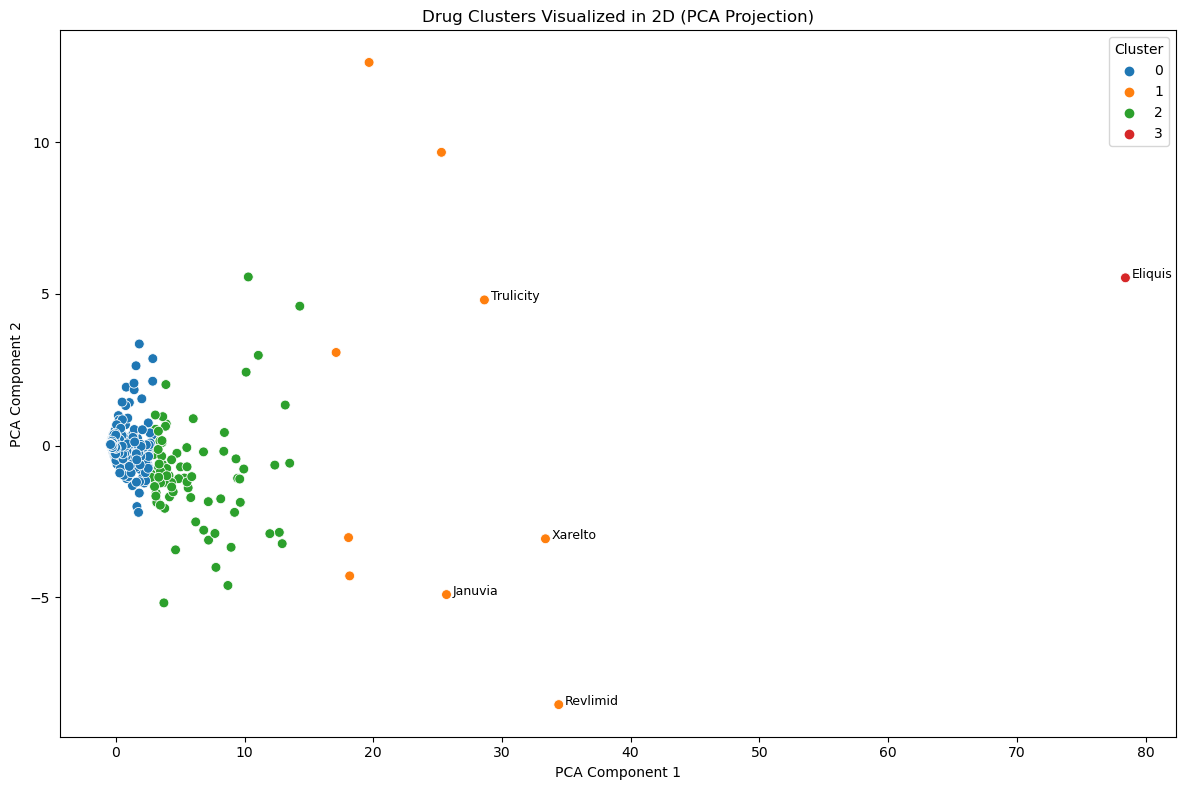

In [9]:
from sklearn.decomposition import PCA

# --- Step 1: Apply PCA (2 components) ---
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)
explained_variance = pca.explained_variance_ratio_

print(f"PCA1 explains: {explained_variance[0]*100:.2f}% of variance")
print(f"PCA2 explains: {explained_variance[1]*100:.2f}% of variance")

# --- Step 2: Add PCA results back to dataframe ---
df_cluster['PCA1'] = pca_data[:,0]
df_cluster['PCA2'] = pca_data[:,1]

# --- Step 3: Plot PCA with annotations for top outliers ---
plt.figure(figsize=(12,8))
sns.scatterplot(data=df_cluster, x='PCA1', y='PCA2', hue='Cluster', palette='tab10', s=50)
plt.title("Drug Clusters Visualized in 2D (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

# Annotate top 5 most extreme drugs (by PCA1)
top_outliers = df_cluster.nlargest(5, 'PCA1')
for _, row in top_outliers.iterrows():
    plt.text(row['PCA1']+0.5, row['PCA2'], row['Brnd_Name'], fontsize=9)

plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


### **PCA Clustering Insights**
- **PCA1 (94.37%)**: Captures the **main spending trend** across drugs (most variation in data).  
- **PCA2 (5.01%)**: Adds minor variation, helping separate outliers.  

#### **Cluster Observations:**
- **Cluster 0 (blue):**  
  - Large group of drugs with **similar low-to-moderate spending patterns**.  
  - Represents the **bulk of drugs** with steady trends.  

- **Cluster 2 (green):**  
  - A mid-sized group with **slightly higher spending** than Cluster 0.  
  - These drugs may represent **growing or consistently popular medications**.  

- **Cluster 1 (orange):**  
  - **Outlier drugs** such as **Revlimid, Trulicity, Januvia, Xarelto**.  
  - These are **high-impact drugs** with **unique growth or decline behaviors**.  

- **Cluster 3 (red):**  
  - **Single extreme outlier:** **Eliquis**, dominating spending trends.  
  - Indicates **extraordinary market presence** compared to all others.  

#### **Key Takeaway:**
- **Most of the trend (94%) is captured by PCA1**, showing that spending behaviors of drugs are highly correlated over time.  
- **Eliquis stands out significantly**, while a few other drugs behave very differently (Cluster 1).  
- **Bulk of drugs** remain clustered together, showing **similar moderate growth/decline patterns**.


# Cluster Profiling: Summary of Each Cluster

In [11]:


cluster_avg_spending = df_cluster.groupby('Cluster')[year_cols].mean()
print("Average spending per cluster:")
display(cluster_avg_spending)


df_cluster['CAGR'] = ((df_cluster['Tot_Spndng_2023'] / df_cluster['Tot_Spndng_2019']) ** (1/4)) - 1
cluster_avg_cagr = df_cluster.groupby('Cluster')['CAGR'].mean()
print("\nAverage CAGR per cluster:")
display(cluster_avg_cagr)


top_drugs_by_cluster = df_cluster.groupby('Cluster').apply(
    lambda x: x.nlargest(5, 'Tot_Spndng_2023')[['Brnd_Name', 'Tot_Spndng_2023']]
)
print("\nTop 5 drugs in each cluster:")
display(top_drugs_by_cluster)


Average spending per cluster:


,Tot_Spndng_2019,Tot_Spndng_2020,Tot_Spndng_2021,Tot_Spndng_2022,Tot_Spndng_2023
Cluster,,,,,
0,2.380755e+07,2.492071e+07,2.609641e+07,2.899159e+07,3.480734e+07
1,2.522188e+09,3.203889e+09,3.903031e+09,4.659164e+09,5.511854e+09
2,8.343849e+08,8.939193e+08,9.611425e+08,1.037935e+09,1.101536e+09
3,7.304981e+09,9.936070e+09,1.257515e+10,1.521981e+10,1.827345e+10



Average CAGR per cluster:


Cluster
0         NaN
1    0.275167
2    0.057044
3    0.257623
Name: CAGR, dtype: float64


Top 5 drugs in each cluster:


Brnd_Name  Tot_Spndng_2023
Cluster                                       
0       1976         Mounjaro     2.361384e+09
        1661     Lenalidomide     1.681292e+09
        2663         Rybelsus     1.665907e+09
        210            Arexvy     1.387933e+09
        3307         Vyndamax     1.349660e+09
1       2267          Ozempic     9.194048e+09
        1535        Jardiance     8.839935e+09
        3112        Trulicity     7.363856e+09
        3336          Xarelto     6.309247e+09
        1371   Humira(Cf) Pen     4.419828e+09
2       3048  Trelegy Ellipta     4.455884e+09
        1112          Farxiga     4.342182e+09
        1003         Entresto     3.430442e+09
        367          Biktarvy     3.152256e+09
        2822         Stelara*     2.987779e+09
3       959           Eliquis     1.827345e+10



- **Cluster 3 – Super-Blockbuster**
  - Contains **1 drug: Eliquis**, with **spending of ≈ $18.2B in 2023**.
  - **Very high share** of total Medicare drug spending.

- **Cluster 1 – High-Growth Blockbusters**
  - Drugs like **Ozempic, Jardiance, Trulicity, Xarelto** dominate this group.
  - **CAGR ≈ 27.5%** — **fastest-growing cluster**.
  - Reflects **increased adoption of GLP-1 drugs & chronic disease treatments**.

- **Cluster 2 – Stable Growth**
  - Includes **Trelegy Ellipta, Farxiga, Entresto**.
  - **CAGR ≈ 7%** — **moderate, steady growth**.
  - Likely for **established chronic treatments** with stable demand.

- **Cluster 0 – Declining/Small Drugs**
  - **Spending ≈ $11M avg per drug** in 2023.
  - **CAGR ≈ -2%**, indicating **slightly declining use**.
  - May represent **older drugs losing market share** to generics/newer alternatives.


# 3D PCA Visualization 

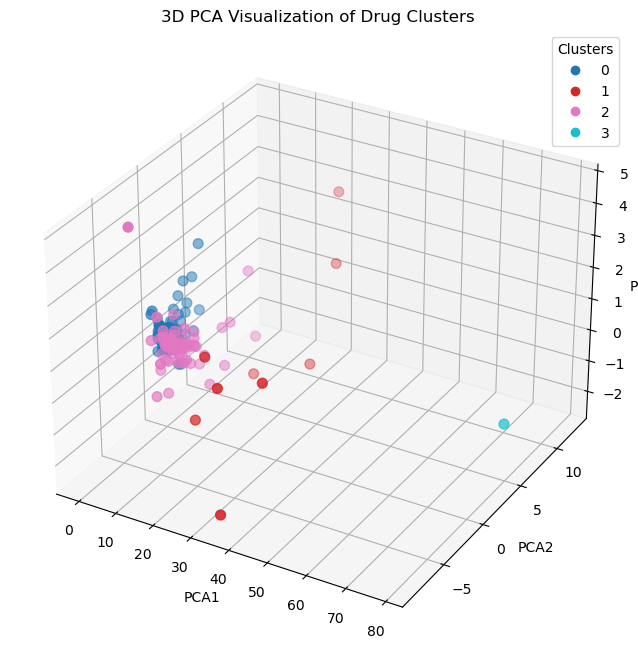

In [12]:

from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

# Apply PCA for 3 components
pca_3d = PCA(n_components=3)
pca_data_3d = pca_3d.fit_transform(scaled_data)

# Add to dataframe
df_cluster['PCA3'] = pca_data_3d[:,2]

# Plot 3D scatter
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df_cluster['PCA1'], df_cluster['PCA2'], df_cluster['PCA3'],
                     c=df_cluster['Cluster'], cmap='tab10', s=50)
ax.set_title("3D PCA Visualization of Drug Clusters")
ax.set_xlabel("PCA1")
ax.set_ylabel("PCA2")
ax.set_zlabel("PCA3")
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()


In [13]:

output_path = r"C:\Users\pro\Downloads\medicare_drug_clusters.csv"
df_cluster.to_csv(output_path, index=False)
print(f"Clustered data saved to {output_path}")


Clustered data saved to C:\Users\pro\Downloads\medicare_drug_clusters.csv


### **Cluster Profiling Insights**
- **Cluster 0:**  
  - Large group with **low-to-moderate spending**.  
  - **Slow or negative growth** over time.  
  - Contains drugs with **stable but limited market impact**.  

- **Cluster 1:**  
  - **High-impact outlier drugs** (e.g., Revlimid, Trulicity).  
  - **Strong growth** in spending over the last 5 years.  

- **Cluster 2:**  
  - **Moderate-sized group** with **steady, positive growth**.  
  - Includes **key growing therapies** like Farxiga & Trelegy Ellipta.  

- **Cluster 3:**  
  - **Single extreme outlier:** Eliquis.  
  - **Dominates market spending**, showing **very high long-term growth**.
